In [1]:
!pip install torchlars

  Preparing metadata (setup.py) ... - \ done
  Created wheel for torchlars: filename=torchlars-0.1.2-cp310-cp310-linux_x86_64.whl size=170645 sha256=9ac4cf7ec5ff6a6ce99f0898b1ab4e2cc402a4fe30ecdd4445fc2f5f4279bf0e
  Stored in directory: /root/.cache/pip/wheels/b4/91/c8/c631927a6e259206b572e7461e6d049b4379d27523c1065e30
Successfully built torchlars


In [2]:
import os
import cv2
import h5py
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchlars import LARS
from sklearn.metrics import roc_auc_score
from transformers import AutoModel, AutoTokenizer
import torchmetrics
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR,ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler, Sampler
from torch.optim import Adam, SGD
from torchvision import transforms, models
from torch.utils.data import Dataset
from torchvision.transforms import Resize, ToTensor
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)

In [3]:
gpus = torch.cuda.device_count()
if gpus <= 1:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'Using {gpus} GPU')
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using {gpus} GPUs')


Using 2 GPUs


In [4]:
MIX = False
if MIX:
    scaler = GradScaler()
    print('Mixed precision enabled')
else:
    print('Using full precision')

Using full precision


In [5]:
columns_to_keep = list(range(22)) 
dataset = pd.read_csv("/kaggle/input/vit-data/HIGGS.csv/HIGGS.csv", usecols=columns_to_keep)

In [6]:
dataset.head()

,1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,...,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00.1,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 22 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   1.000000000000000000e+00    float64
 1   8.692932128906250000e-01    float64
 2   -6.350818276405334473e-01   float64
 3   2.256902605295181274e-01    float64
 4   3.274700641632080078e-01    float64
 5   -6.899932026863098145e-01   float64
 6   7.542022466659545898e-01    float64
 7   -2.485731393098831177e-01   float64
 8   -1.092063903808593750e+00   float64
 9   0.000000000000000000e+00    float64
 10  1.374992132186889648e+00    float64
 11  -6.536741852760314941e-01   float64
 12  9.303491115570068359e-01    float64
 13  1.107436060905456543e+00    float64
 14  1.138904333114624023e+00    float64
 15  -1.578198313713073730e+00   float64
 16  -1.046985387802124023e+00   float64
 17  0.000000000000000000e+00.1  float64
 18  6.579295396804809570e-01    float64
 19  -1.0454569943249225

In [8]:
y = dataset.iloc[:,0]  
X = dataset.iloc[:, 1:]

In [9]:
class_distribution = y.value_counts()
print("Class Distribution:")
print(class_distribution)

Class Distribution:
1.000000000000000000e+00
1.0    5829122
0.0    5170877
Name: count, dtype: int64


In [10]:
X = (X - np.mean(X))/np.std(X)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=100000, stratify = y,random_state=42)

In [12]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

In [13]:
class CFG:
    lr = 1e-3
    weight_decay = 5e-4
    input_dim = 21
    latent_dim = 64
    num_classes = 1
    num_layers = 2
    num_heads = 3
    dropout = 0.1
    num_epochs = 15
    batch_size = 1024

In [14]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size)

In [15]:
class TransformerAutoencoderClassifier(nn.Module):
    def __init__(self, input_dim=21, latent_dim=64, num_classes=1, num_layers=2, num_heads=3, dropout=0.1):
        super(TransformerAutoencoderClassifier, self).__init__()
        
        self.input_dim = input_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        
        self.encoder_layers = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=num_layers)
        self.decoder_layers = nn.TransformerDecoderLayer(d_model=input_dim, nhead=num_heads)
        self.decoder = nn.TransformerDecoder(self.decoder_layers, num_layers=num_layers)
        self.bottleneck = nn.Linear(input_dim, latent_dim)
        self.classifier = nn.Linear(latent_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        tgt_mask = self.generate_square_subsequent_mask(x.size(0))
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(x, encoder_output, tgt_mask=tgt_mask)
        bottleneck_output = self.bottleneck(encoder_output)
        classification_output = torch.sigmoid(self.classifier(bottleneck_output))
        return decoder_output, classification_output

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [16]:
model = TransformerAutoencoderClassifier(
    input_dim=CFG.input_dim,
    latent_dim=CFG.latent_dim,
    num_classes=CFG.num_classes,
    num_layers=CFG.num_layers,
    num_heads=CFG.num_heads,
    dropout=CFG.dropout
).to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [17]:
criterion_autoencoder = nn.MSELoss()
criterion_classification = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr,weight_decay = CFG.weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.4, threshold=1e-2, verbose=True)

In [18]:
    model.eval()
    val_running_loss = 0
    correct_val = 0
    total_val = 0
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        with tqdm(val_loader, desc="Validation", leave=False) as val_loader_with_progress:
            for val_inputs, val_labels in val_loader_with_progress:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                decoder_output, classification_output = model(val_inputs)
                autoencoder_loss = criterion_autoencoder(decoder_output, val_inputs)
                classification_loss = criterion_classification(classification_output.squeeze(), val_labels.float())
                outputs = classification_output.squeeze()
                val_loss = 0.5 * autoencoder_loss + 0.5 * classification_loss
                val_running_loss += val_loss.item()
                predicted_val = torch.round(outputs)
                correct_val += (predicted_val == val_labels).sum().item()
                total_val += val_labels.size(0)
                y_true += val_labels.cpu().detach().numpy().tolist()
                y_scores += outputs.cpu().detach().numpy().tolist()
                val_loader_with_progress.set_postfix(val_loss=val_loss.item())
                
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_roc_auc = roc_auc_score(y_true, y_scores)
    
    print(f'At 0th epoch without training Validation Loss: {val_loss}, Validation AUC-ROC: {val_roc_auc}, Validation Accuracy: {val_acc}')

At 0th epoch without training Validation Loss: 0.6688414003167834, Validation AUC-ROC: 0.5356739359430778, Validation Accuracy: 53.334


In [19]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_roc_aucs = []
val_roc_aucs = []
best_val_accuracy = 0.0
best_model_state_dict = None

for epoch in range(CFG.num_epochs):
    model.train()
    train_running_loss = 0
    correct_train = 0
    total_train = 0
    y_true = []
    y_scores = []

    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.num_epochs}", leave=False) as train_loader_with_progress:
        for inputs, labels in train_loader_with_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            decoder_output, classification_output = model(inputs)
            autoencoder_loss = criterion_autoencoder(decoder_output, inputs)
            classification_loss = criterion_classification(classification_output.squeeze(), labels.float())  
            loss = 0.5 * autoencoder_loss + 0.5 * classification_loss  
            outputs = classification_output.squeeze()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=3)
            optimizer.step()
            train_running_loss += loss.item()
            predicted_train = torch.round(outputs)
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)
            train_loader_with_progress.set_postfix(train_loss=loss.item())
            y_true += labels.cpu().detach().numpy().tolist()
            y_scores += outputs.cpu().detach().numpy().tolist()
    
    train_loss = train_running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    roc_auc_train = roc_auc_score(y_true, y_scores)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_roc_aucs.append(roc_auc_train)

    model.eval()
    val_running_loss = 0
    correct_val = 0
    total_val = 0
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Epoch {epoch + 1}/{CFG.num_epochs} Validation", leave=False) as val_loader_with_progress:
            for val_inputs, val_labels in val_loader_with_progress:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                decoder_output, classification_output = model(val_inputs)
                autoencoder_loss = criterion_autoencoder(decoder_output, val_inputs)
                classification_loss = criterion_classification(classification_output.squeeze(), val_labels.float())
                outputs = classification_output.squeeze()
                val_loss = 0.5 * autoencoder_loss + 0.5 * classification_loss
                val_running_loss += val_loss.item()
                predicted_val = torch.round(outputs)
                correct_val += (predicted_val == val_labels).sum().item()
                total_val += val_labels.size(0)
                y_true += val_labels.cpu().detach().numpy().tolist()
                y_scores += outputs.cpu().detach().numpy().tolist()
                val_loader_with_progress.set_postfix(val_loss=val_loss.item())
                
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_roc_auc = roc_auc_score(y_true, y_scores)
    
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_roc_aucs.append(val_roc_auc)
    scheduler.step(val_loss)
    for param_group in optimizer.param_groups:
        print(f'Learning Rate: {param_group["lr"]}')
    
    print(f"Epoch {epoch + 1}/{CFG.num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Train ROC-AUC: {roc_auc_train:.3f}, Val ROC-AUC: {val_roc_auc:.3f}")
    
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state_dict = model.state_dict()
        torch.save(best_model_state_dict, "model_weights_Transformer_Autoencoder.pth")

print("Model saved successfully.")
print("Finished training")
           

Learning Rate: 0.001
Epoch 1/15, Train Loss: 0.3143, Train Acc: 68.10%, Val Loss: 0.2922, Val Acc: 70.61%, Train ROC-AUC: 0.746, Val ROC-AUC: 0.778


Learning Rate: 0.001
Epoch 2/15, Train Loss: 0.2939, Train Acc: 70.58%, Val Loss: 0.2825, Val Acc: 71.95%, Train ROC-AUC: 0.775, Val ROC-AUC: 0.796


Learning Rate: 0.001
Epoch 3/15, Train Loss: 0.2889, Train Acc: 71.37%, Val Loss: 0.2784, Val Acc: 72.67%, Train ROC-AUC: 0.785, Val ROC-AUC: 0.803


Learning Rate: 0.001
Epoch 4/15, Train Loss: 0.2859, Train Acc: 71.83%, Val Loss: 0.2752, Val Acc: 73.11%, Train ROC-AUC: 0.790, Val ROC-AUC: 0.808


Learning Rate: 0.001
Epoch 5/15, Train Loss: 0.2839, Train Acc: 72.14%, Val Loss: 0.2732, Val Acc: 73.47%, Train ROC-AUC: 0.794, Val ROC-AUC: 0.812


Learning Rate: 0.001
Epoch 6/15, Train Loss: 0.2825, Train Acc: 72.34%, Val Loss: 0.2716, Val Acc: 73.70%, Train ROC-AUC: 0.796, Val ROC-AUC: 0.815


Learning Rate: 0.001
Epoch 7/15, Train Loss: 0.2812, Train Acc: 72.54%, Val Loss: 0.2707, Val Acc: 73.81%, Train ROC-AUC: 0.799, Val ROC-AUC: 0.816


Epoch 00008: reducing learning rate of group 0 to 4.0000e-04.
Learning Rate: 0.0004
Epoch 8/15, Train Loss: 0.2803, Train Acc: 72.67%, Val Loss: 0.2697, Val Acc: 73.88%, Train ROC-AUC: 0.800, Val ROC-AUC: 0.818


Learning Rate: 0.0004
Epoch 9/15, Train Loss: 0.2767, Train Acc: 73.17%, Val Loss: 0.2656, Val Acc: 74.48%, Train ROC-AUC: 0.806, Val ROC-AUC: 0.824


Learning Rate: 0.0004
Epoch 10/15, Train Loss: 0.2759, Train Acc: 73.29%, Val Loss: 0.2646, Val Acc: 74.64%, Train ROC-AUC: 0.808, Val ROC-AUC: 0.826


Epoch 00011: reducing learning rate of group 0 to 1.6000e-04.
Learning Rate: 0.00016
Epoch 11/15, Train Loss: 0.2754, Train Acc: 73.33%, Val Loss: 0.2643, Val Acc: 74.64%, Train ROC-AUC: 0.808, Val ROC-AUC: 0.826


Learning Rate: 0.00016
Epoch 12/15, Train Loss: 0.2737, Train Acc: 73.55%, Val Loss: 0.2627, Val Acc: 74.87%, Train ROC-AUC: 0.811, Val ROC-AUC: 0.828


Learning Rate: 0.00016
Epoch 13/15, Train Loss: 0.2733, Train Acc: 73.60%, Val Loss: 0.2623, Val Acc: 74.86%, Train ROC-AUC: 0.812, Val ROC-AUC: 0.829


Epoch 00014: reducing learning rate of group 0 to 6.4000e-05.
Learning Rate: 6.400000000000001e-05
Epoch 14/15, Train Loss: 0.2731, Train Acc: 73.63%, Val Loss: 0.2628, Val Acc: 74.87%, Train ROC-AUC: 0.812, Val ROC-AUC: 0.829


Learning Rate: 6.400000000000001e-05
Epoch 15/15, Train Loss: 0.2724, Train Acc: 73.70%, Val Loss: 0.2617, Val Acc: 74.99%, Train ROC-AUC: 0.813, Val ROC-AUC: 0.830
Model saved successfully.
Finished training


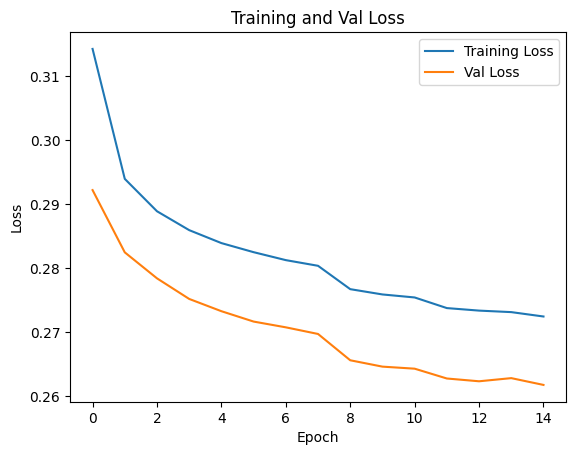

In [20]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Val Loss")
plt.legend()
plt.show()

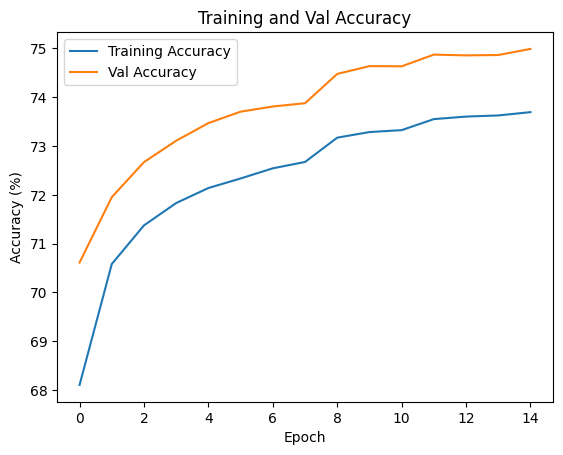

In [21]:
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Val Accuracy")
plt.legend()
plt.show()

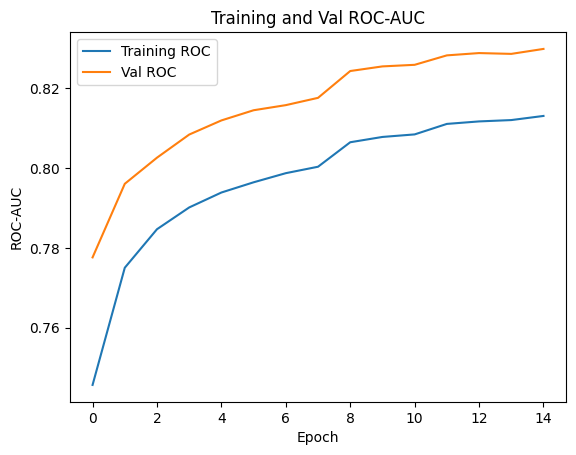

In [22]:
plt.plot(train_roc_aucs, label="Training ROC")
plt.plot(val_roc_aucs, label="Val ROC")
plt.xlabel("Epoch")
plt.ylabel("ROC-AUC")
plt.title("Training and Val ROC-AUC")
plt.legend()
plt.show()